# 项目 - 航空公司 AI 助手

现在我们将整合所学知识，为一家航空公司制作一个 AI 客服助手

In [1]:
# 导入库

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# 初始化

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API 密钥存在，前缀为 {openai_api_key[:8]}")
else:
    print("未设置 OpenAI API 密钥")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API 密钥存在，前缀为 sk-proj-


In [3]:
system_message = "你是一家名为 FlightAI 的航空公司的乐于助人的助手。 "
system_message += "请给出简短、礼貌的回答，不超过一句话。 "
system_message += "回答务必准确。如果不知道答案，请如实说明。"

In [4]:
# 这个函数看起来比我视频中的那个要简单得多，因为我们利用了最新的 Gradio 更新

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## 工具

工具是前沿 LLM 提供的一个极其强大的功能。

通过工具，你可以编写一个函数，并让 LLM 在其响应中调用该函数。

听起来有点吓人……我们是给了它在我们的机器上运行代码的权力吗？

嗯，差不多吧。

In [5]:
# 让我们从创建一个有用的函数开始

ticket_prices = {"北京": "799", "上海": "899", "成都": "1400", "济南": "499"}

def get_ticket_price(destination_city):
    print(f"工具 get_ticket_price 已为 {destination_city} 调用")
    city = destination_city.lower()
    return ticket_prices.get(city, "未知")

In [6]:
get_ticket_price("济南")

工具 get_ticket_price 已为 济南 调用


'499'

In [7]:
# 描述我们的函数需要一个特定的字典结构：

price_function = {
    "name": "get_ticket_price",
    "description": "获取到目的地城市的往返机票价格。当您需要知道机票价格时（例如，当客户询问‘到这个城市的机票多少钱’时），请调用此函数",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "客户想要前往的城市",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [8]:
# 然后将其包含在一个工具列表中：

tools = [{"type": "function", "function": price_function}]

## 让 OpenAI 使用我们的工具

要让 OpenAI “调用我们的工具”，需要一些繁琐的设置

我们实际做的是给 LLM 一个机会，让它通知我们它希望我们运行这个工具。

新的聊天函数看起来是这样的：

In [9]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [10]:
# 我们必须编写 handle_tool_call 函数：

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# 让我们进入多模态！！

我们可以使用 DALL-E-3，即 GPT-4o 背后的图像生成模型，来为我们制作一些图像

让我们把这个功能放到一个名为 artist 的函数中。

### 价格提醒：每次我生成一张图片大约花费 4 美分 - 不要疯狂生成图片！

In [12]:
# 用于处理图像的一些导入

import base64
from io import BytesIO
from PIL import Image

In [13]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"一幅代表在 {city} 度假的照片，以充满活力的波普艺术风格展示旅游景点和 {city} 的一切独特之处",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

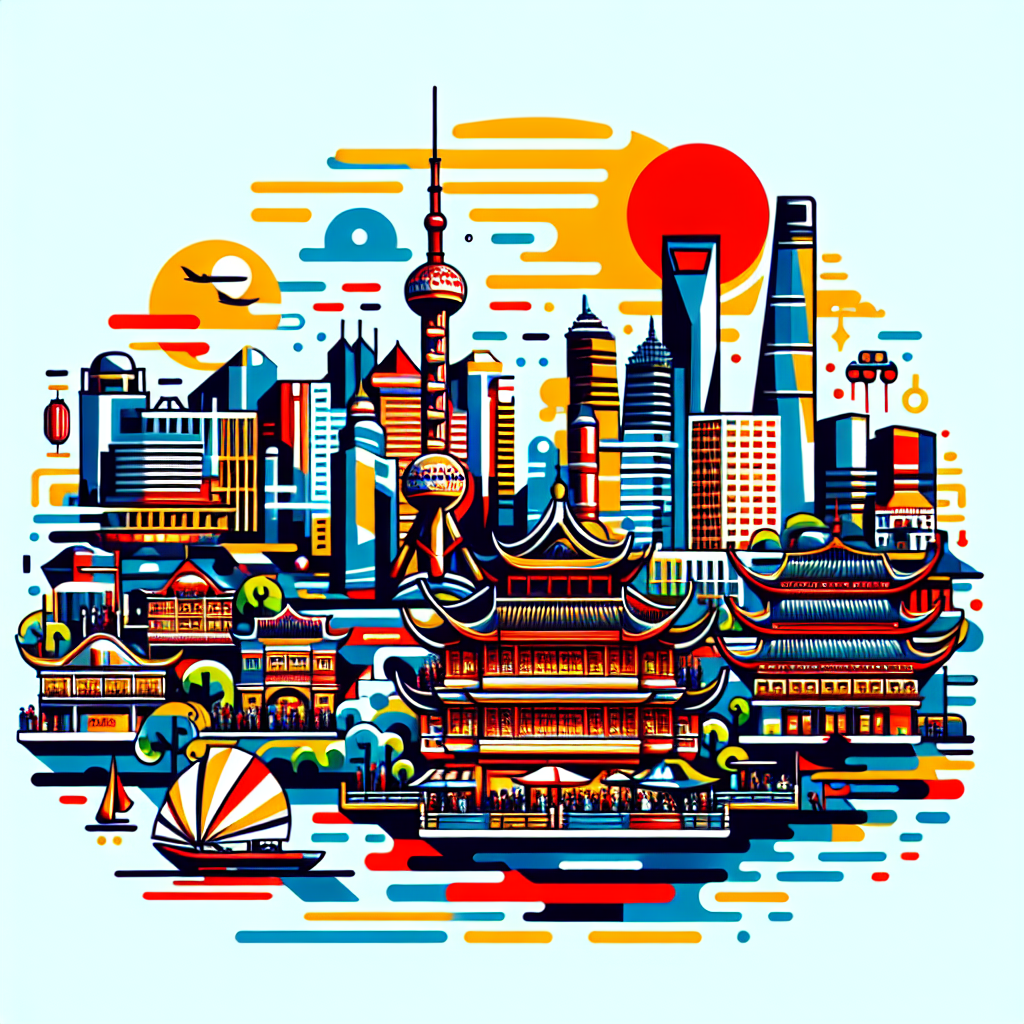

In [14]:
image = artist("上海")
display(image)

## 音频（注意 - 音频是本课程的可选部分 - 如果遇到问题，可以随时跳过音频！）

让我们创建一个名为 talker 的函数，使用 OpenAI 的语音模型来生成音频

### 音频问题故障排除

如果您在运行下面的代码时遇到任何问题（例如 FileNotFound 错误，或缺少包的警告），您可能需要安装 FFmpeg，一个非常流行的音频工具。

**对于 PC 用户**

详细说明在[这里](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905)，简要说明如下：

1. 从官方网站下载 FFmpeg：https://ffmpeg.org/download.html

2. 将下载的文件解压到您计算机上的一个位置（例如，`C:\ffmpeg`）

3. 将 FFmpeg 的 bin 文件夹添加到您的系统 PATH：
- 右键点击“此电脑”或“我的电脑”，选择“属性”
- 点击“高级系统设置”
- 点击“环境变量”
- 在“系统变量”下，找到并编辑“Path”
- 添加一个新条目，路径为您的 FFmpeg bin 文件夹（例如，`C:\ffmpeg\bin`）
- 重启您的命令提示符，并在 Jupyter Lab 中执行 内核 -> 重启内核，以应用更改

4. 打开一个新的命令提示符并运行此命令，以确保其已正确安装
`ffmpeg -version`

**对于 Mac 用户**

1. 如果您还没有 homebrew，请在终端窗口中运行此命令并按照任何说明进行安装：
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. 然后使用 `brew install ffmpeg` 安装 FFmpeg

3. 使用 `ffmpeg -version` 验证您的安装，如果一切正常，在 Jupyter Lab 中执行 内核 -> 重启内核 以应用更改


## 检查您现在是否已安装 ffmpeg 并且可以在此处访问

执行下一个单元格，看看是否能得到版本号。（在 Jupyter Lab 中，在命令前加上感叹号表示将其作为终端命令而不是 python 代码运行）。

如果这不起作用，您可能需要实际保存并关闭 Jupyter Lab，然后从一个新的终端窗口（Mac）或 Anaconda 提示符（PC）重新启动它，并记住激活 llms 环境。这确保您能加载 ffmpeg。

In [ ]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

# 适用于 Mac 用户 - 可能也适用于许多 PC 用户

这个版本对您来说应该可以正常工作。它也可能适用于 Windows 用户，但您可能会在写入临时文件时遇到权限错误。如果是这样，请参阅下一部分！

（如果您对音频生成不太感兴趣，也可以在后面的代码中注释掉音频 talker()）

In [18]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # 另外，可以尝试用 alloy 替换 onyx
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [19]:
talker("你好呀")

Input #0, wav, from '/var/folders/1h/5lrr936116vb7f6_ngch9f080000gn/T/tmp6l71z1bx.wav':
  Duration: 00:00:00.70, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   0.66 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

# 适用于 Windows 用户（或任何遇到上述问题的 Mac 用户）

## 首先尝试上面的 Mac 版本，但如果您在写入临时文件时遇到权限错误，那么此代码应该可以替代。


下面是 4 个变体 - 希望其中一个能在您的 PC 上工作。如果不行，请给我发消息！

对于 Mac 用户 - 下面所有 3 个在我的 Mac 上也能工作 - 如果 Mac 版本给您带来了问题，请尝试这些。

## PC 变体 1

In [ ]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # 播放生成的音频
    display(Audio(output_filename, autoplay=True))

talker("你好呀")

## PC 变体 2

In [ ]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # 学生发现这是必需的。您也可以尝试注释掉，看看在您的 PC 上是否需要
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # 另外，可以尝试用 alloy 替换 onyx
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

talker("你好呀")

## PC 变体 3

In [ ]:
import os
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO

def talker(message):
    # 在 Windows 上为临时文件设置一个自定义目录
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.environ['TEMP'] = custom_temp_dir  # 如果需要，您也可以使用 'TMP'
    
    # 如果文件夹不存在则创建
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # 另外，可以尝试用 alloy 替换 onyx
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    play(audio)

talker("你好呀")

## PC 变体 4

### 让我们尝试一个完全不同的声音库

首先运行下一个单元格来安装一个新库，然后尝试它下面的单元格。

In [ ]:
!pip install simpleaudio

In [ ]:
from pydub import AudioSegment
from io import BytesIO
import tempfile
import os
import simpleaudio as sa

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # 另外，可以尝试用 alloy 替换 onyx
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # 在您有写入权限的文件夹中创建一个临时文件
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
        temp_file_name = temp_audio_file.name
        audio.export(temp_file_name, format="wav")
    
    # 使用 simpleaudio 加载并播放音频
    wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
    play_obj = wave_obj.play()
    play_obj.wait_done()  # 等待播放完成

    # 之后清理临时文件
    os.remove(temp_file_name)
    
talker("你好呀")

## PC 用户 - 如果这 4 个变体都不起作用！

另外：从您的 PC 播放音频对于本课程并非至关重要，您可以暂时跳过音频，专注于图像生成，或稍后再回来处理。

# 我们的 Agent 框架

术语“Agentic AI”和“Agentization”是一个总称，指的是多种技术，例如：

1. 将复杂问题分解为更小的步骤，由多个 LLM 执行专门任务
2. LLM 使用工具赋予其额外能力的能力
3. 允许 Agent 协作的“Agent 环境”
4. 一个 LLM 可以充当规划者，将更大的任务分解为更小的任务给专家
5. Agent 具有自主性/能动性的概念，超越了仅仅响应提示 - 例如记忆

我们在这里展示了 1 和 2，以及在较小程度上展示了 3 和 5。在第 8 周，我们将全部实现！

In [ ]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # 如果您暂时想跳过音频，请注释掉或删除下一行..
    talker(reply)
    
    return history, image

In [ ]:
# 更复杂的 Gradio 代码，因为我们没有使用预设的聊天界面！
# 在最后一行传入 inbrowser=True 会立即弹出一个 Gradio 窗口。

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="与我们的 AI 助手聊天：")
    with gr.Row():
        clear = gr.Button("清除")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

# 练习和商业应用

添加更多工具 - 也许可以模拟实际预订航班。

下一步：将此应用于您的业务。制作一个带有工具的多模态 AI 助手，可以为您的工作执行活动。一个客户支持助手？新员工入职助手？可能性太多了！另外，请参阅单独笔记本中的第 2 周周末练习。